In [1]:
import numpy as np
import nibabel as nib

from utils import calculate_dice_score
from em_algo import ExpectationMaximization

## Load Data

In [73]:
patient = 3

In [74]:
# Load the two NIfTI images
T1_path = f'data/{patient}/T1.nii'
T2_path = f'data/{patient}/T2_FLAIR.nii'
label_path = f'data/{patient}/LabelsForTesting.nii'

### Load the images from the path
T1 = nib.load(T1_path)
T1_np_img = T1.get_fdata()
T2 = nib.load(T2_path)
T2_np_img = T2.get_fdata()
labels = nib.load(label_path)
labels_np_img = labels.get_fdata()

In [75]:
# Perform Skull Stripping to get the brain mask for WM, GM, and CSF
## Isolate the brain voxels using the label
#### Get the indices of the brain voxels
brain_voxels_indices = np.where(labels_np_img > 0)
#### Get the brain voxels from the T1 image using the indices get from the label
T1_skull_stripped = T1_np_img[brain_voxels_indices]

### Stack the T1 and T2 images to get the multi-modal image
X = np.expand_dims(T1_skull_stripped, axis=1)

## EM Algorithm

Iteration:  0  --- Log Likelihood:  7.470107275365405  --- Time (s):  0.03746771812438965


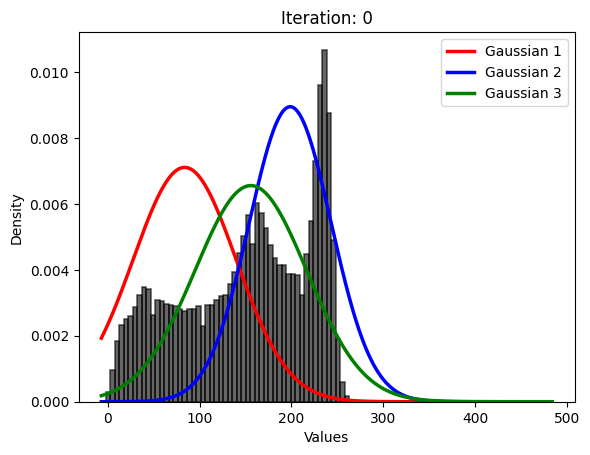

Iteration:  1  --- Log Likelihood:  7.482603184245657  --- Time (s):  0.0758969783782959
Iteration:  2  --- Log Likelihood:  7.490609261750791  --- Time (s):  0.03634190559387207
Iteration:  3  --- Log Likelihood:  7.4968035638212385  --- Time (s):  0.03784012794494629
Iteration:  4  --- Log Likelihood:  7.501751615806671  --- Time (s):  0.03876614570617676
Iteration:  5  --- Log Likelihood:  7.505757266971772  --- Time (s):  0.03706502914428711
Iteration:  6  --- Log Likelihood:  7.509252538655853  --- Time (s):  0.039304256439208984
Iteration:  7  --- Log Likelihood:  7.512673880133905  --- Time (s):  0.03946709632873535
Iteration:  8  --- Log Likelihood:  7.51642157767883  --- Time (s):  0.03771495819091797
Iteration:  9  --- Log Likelihood:  7.5209009970201  --- Time (s):  0.03714704513549805
Iteration:  10  --- Log Likelihood:  7.526587671359676  --- Time (s):  0.038785696029663086
Iteration:  11  --- Log Likelihood:  7.534086172519358  --- Time (s):  0.03700709342956543
Iteration

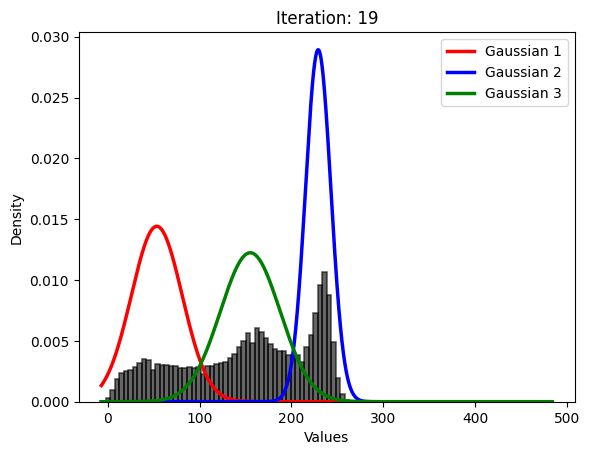

In [76]:
# Initialize the Expectation Maximization algorithm
em = ExpectationMaximization(X, k=3, max_iter=20, type='kmeans', plot_step=25, save_path='results/', show_plot=True, stop_criterion=1e-6)
alphas, mus, covars, W = em.fit()

## Postprocessing

Sort the means of the Gaussian components. This helps us map the classes to the intensity ranges.  
	•	The smallest mean will be assigned to CSF (1).  
	•	The middle mean will be assigned to GM (2).  
	•	The largest mean will be assigned to WM (3).  

In [77]:
# Assign each voxel to the cluster with the highest probability
voxel_assignments = np.argmax(W, axis=1)  # Get the index of the highest responsibility for each voxel
# Create a new 3D image with the same shape as the original brain image
segmented_image = np.zeros_like(T1_np_img)
# Map the voxel assignments back to the 3D segmented image using the brain_voxels_indices
segmented_image[brain_voxels_indices] = voxel_assignments + 1  # +1 to make the clusters 1, 2, 3

In [78]:
## 1 - CSF, 2 - GM, 3 - WM 
## Sort the clusters based on the mean intensity of the voxels in each cluster
sorted_mean_indices = np.argsort(np.mean(mus, axis=1)) + 1
## Assign the clusters to the correct class
class1_idx = np.where(segmented_image == sorted_mean_indices[0])
class2_idx = np.where(segmented_image == sorted_mean_indices[1])
class3_idx = np.where(segmented_image == sorted_mean_indices[2])
segmented_image[class1_idx] = 1
segmented_image[class2_idx] = 2
segmented_image[class3_idx] = 3

# Save the segmented image
segmented_img_nifti = nib.Nifti1Image(segmented_image, T1.affine)
nib.save(segmented_img_nifti, 'results/segmented_brain.nii')

print("Segmented brain image saved as 'results/segmented_brain.nii'")

Segmented brain image saved as 'results/segmented_brain.nii'


## Evaluation

In [79]:
# Calculate the Dice score between the predicted labels and the ground truth
dice_scores = calculate_dice_score(label_path, 'results/segmented_brain.nii')    
print(dice_scores)
print('Average Dice Score: ', np.mean(list(dice_scores.values())))

{1: 0.8259272749347417, 2: 0.7827951725461509, 3: 0.8770742698171781}
Average Dice Score:  0.8285989057660235


## Visualization

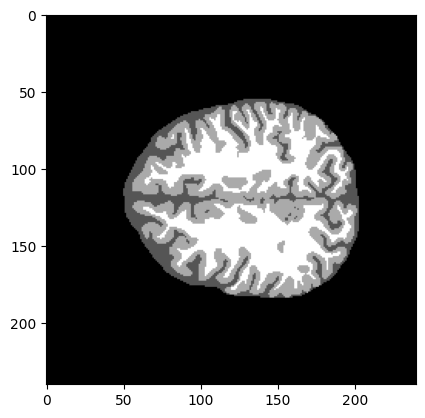

In [56]:
import matplotlib.pyplot as plt
plt.imshow(labels_np_img[:,:, 30], cmap='gray')
plt.show()

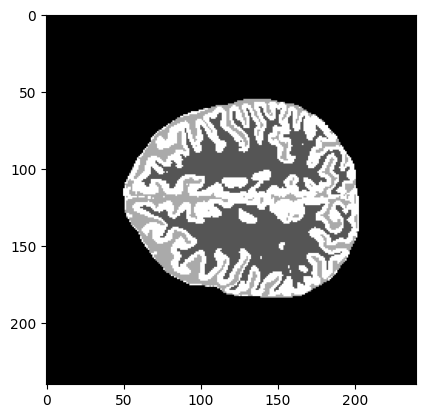

In [48]:
import matplotlib.pyplot as plt
plt.imshow(segmented_image[:,:, 30], cmap='gray')
plt.show()